In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
import re

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
start_year = 1993
curr_year = datetime.now().year

In [2]:
# Custom API
from sys import path

path.append('../API/fetch')
import data_fetch as fetch

path.append('../API/preprocess')
from data_pipeline import dataset_pipeline, feature_pipeline, bracket_pipeline

path.append('../API/eda')
from data_visualizations import get_yearly_base_rates, get_seed_pairs, format_plot

path.append('../API/model')
from model_selection import get_cv_models
from model_evaluation import evaluate_cv_models, get_classification_report

# Data Fetching

## Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
<br>**Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won**

<br>And lastly, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (0-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?**

## Examples

### Team Regular Season Stats

In [3]:
fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-school-stats.html",
                    attrs={'id': 'basic_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,409,584,.700,NaN,965,285,178,109,385,546
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,320,493,.649,NaN,795,315,163,47,352,573
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,456,650,.702,NaN,1273,501,246,135,498,650
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,541,767,.705,NaN,1049,395,194,42,556,567
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,458,702,.652,NaN,1117,337,185,120,487,539


In [4]:
fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-advanced-school-stats.html", 
                    attrs={'id': 'adv_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,.279,.500,49.9,44.3,NaN,9.6,.458,17.4,NaN,.263
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,.277,.517,51.1,54.3,NaN,5.5,.488,18.4,NaN,.241
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,.270,.527,52.2,56.4,NaN,9.6,.494,17.8,NaN,.228
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,.203,.557,51.3,46.4,NaN,2.8,.518,20.7,NaN,.305
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,.299,.541,51.7,43.1,NaN,8.9,.513,19.4,NaN,.271


### Team Rankings

In [5]:
fetch.get_rankings_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-ratings.html").head()

,Team,Top_25
2,North Carolina,1
3,Kentucky,1
4,Duke,1
5,Indiana,1
6,Cincinnati,1


### Coach Tournament Performance

In [6]:
fetch.get_coach_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-coaches.html").head()

,Coach_Team,MM,S16,F4,Champs
2,Air Force,,,,
3,Akron,,,,
4,Alabama,,,,
5,Alabama-Birmingham,11,5,2,
6,Alabama State,,,,


### Tournament Game Data

In [7]:
fetch.get_team_data(url=("https://apps.washingtonpost.com/sports/search/?pri_school_id=&pri_conference=&pri_coach"
                       "=&pri_seed_from=1&pri_seed_to=16&pri_power_conference=&pri_bid_type=&opp_school_id"
                       "=&opp_conference=&opp_coach=&opp_seed_from=1&opp_seed_to=16&opp_power_conference=&opp_bid_type"
                       f"=&game_type=7&from={start_year}&to={start_year}&submit="), 
                    attrs={'class': 'search-results'}, header=0).head()

,Year,Round,Seed,Team,Score,Seed.1,Team.1,Score.1
0,1993,National ChampionshipNational Championship,1,Michigan Michigan,71,1,North Carolina North Carolina,77
1,1993,Final FourFinal Four,1,Kentucky Kentucky,78,1,Michigan Michigan,81
2,1993,Final FourFinal Four,1,North Carolina North Carolina,78,2,Kansas Kansas,68
3,1993,Elite EightElite Eight,1,Michigan Michigan,77,7,Temple Temple,72
4,1993,Elite EightElite Eight,1,Kentucky Kentucky,106,3,Florida State Florida State,81


# Data Pipeline

Below is the output of a merge of the datasets displayed above (after they've been cleaned). Once we remove the features with nulls that won't be imputed, we can begin our exploratory data analysis (EDA).

In [8]:
# Check if the historical data CSV exists, if it doesn't then create it
try:
    mm_matchups_df = pd.read_csv(f'{curr_year}_march_madness_hist_data.csv')
except FileNotFoundError:
    mm_matchups_df = dataset_pipeline(np.arange(start_year, curr_year - 1))
    mm_matchups_df.to_csv(f'{curr_year}_march_madness_hist_data.csv', index=False)

mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,G_Favorite,W-L%_Favorite,SOS_Favorite,...,FG/Game_Underdog,3P/Game_Underdog,FT/Game_Underdog,ORB/Game_Underdog,TRB/Game_Underdog,AST/Game_Underdog,STL/Game_Underdog,BLK/Game_Underdog,TOV/Game_Underdog,PF/Game_Underdog
0,1993,National Championship,1,North Carolina,1,Michigan,0,38.0,0.895,11.25,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
1,1993,Final Four,1,Kentucky,1,Michigan,1,34.0,0.882,9.23,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
2,1993,Final Four,1,North Carolina,2,Kansas,0,38.0,0.895,11.25,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
3,1993,Elite Eight,1,Indiana,2,Kansas,1,35.0,0.886,11.09,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
4,1993,Elite Eight,1,North Carolina,2,Cincinnati,0,38.0,0.895,11.25,...,28.1,5.0,13.2,NaN,36.0,16.0,10.0,2.6,14.1,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2019,First Round,7,Wofford,10,Seton Hall,0,35.0,0.857,0.80,...,26.1,7.1,14.5,10.6,35.7,13.5,6.9,3.9,12.4,18.8
1743,2019,First Round,6,Buffalo,11,Arizona State,0,36.0,0.889,2.62,...,26.4,7.1,17.6,11.7,39.7,13.5,6.3,3.2,13.7,19.9
1744,2019,Play-In,11,Belmont,11,Temple,0,33.0,0.818,-2.60,...,26.5,7.5,14.3,9.6,34.4,14.4,8.6,2.2,11.2,17.6
1745,2019,Play-In,16,North Dakota State,16,North Carolina Central,0,35.0,0.543,-2.07,...,25.7,6.5,13.5,11.7,37.2,15.5,6.1,2.7,15.1,17.9


## Handling Missing Values

### Finding the Nulls

Recall that our cleaned dataset has a total of 1,747 March Madness games present, and each March Madness will consist of no more than 67 games (4 play-in games + 63 tournament games). As can be seen below, the advanced stats pertaining to personal fouls (PF) and turnovers (TOV) are the only features listed with no more than a season's worth of missing data. Given how rapidly the gameplay of college basketball has evolved over the time horizon of our dataset, imputing nulls on multiple years of March Madness data would likely be a futile effort. The features with a high volume of nulls (1> season) will be dropped from the dataset.

In [9]:
# Given that a feature has any nulls, find the number of nulls present
true_nulls = fetch.get_feature_null_counts(mm_matchups_df)
true_nulls

Pace_Underdog        1072
Pace_Favorite        1065
ORB%_Favorite         766
STL%_Favorite         766
ORtg_Favorite         766
STL%_Underdog         765
ORtg_Underdog         765
ORB%_Underdog         764
ORB/Game_Underdog     255
ORB/Game_Favorite     254
PF/Game_Favorite       64
PF/Game_Underdog       64
TOV/Game_Underdog       3
TOV%_Underdog           3
TOV/Game_Favorite       1
TOV%_Favorite           1
dtype: int64

In [10]:
# Get turnover features from true_nulls
tov_null_fills = [col for col in true_nulls.index if ('TOV' in col)]

# Get personal foul features from true_nulls
pf_null_fills = [col for col in true_nulls.index if ('PF' in col)]

# All other features found in true_nulls are dropped from our original dataset
null_drops = list(set(true_nulls.index) - set(tov_null_fills) - set(pf_null_fills))
mm_matchups_df.drop(null_drops, axis=1, inplace=True)

In [11]:
# View the rows containing all of the dataset's nulls to be imputed
# This will be a useful reference to validate the proper imputation of the nulls
tov_nulls_rows = fetch.get_null_rows(tov_null_fills, mm_matchups_df)
pf_nulls_rows = fetch.get_null_rows(pf_null_fills, mm_matchups_df)

display(tov_nulls_rows), display(pf_nulls_rows)

,Year,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
15,1993,NaN,NaN,15.6,17.4
16,1993,NaN,NaN,12.0,15.9
45,1993,17.8,16.6,NaN,NaN
481,2000,NaN,NaN,15.8,17.8


,Year,PF/Game_Favorite,PF/Game_Underdog
568,2002,NaN,NaN
569,2002,NaN,NaN
570,2002,NaN,NaN
571,2002,NaN,NaN
572,2002,NaN,NaN
...,...,...,...
627,2002,NaN,NaN
628,2002,NaN,NaN
629,2002,NaN,NaN
630,2002,NaN,NaN


(None, None)

### What are the Distributions of the Features We Wish to Impute?

Upon looking at the distributions below of all turnover and personal foul features, we can see that they closely resemble a normal distribution. Given this assumption, the features' means will serve as good values for imputing the nulls.

1993 feature distributions
2000 feature distributions


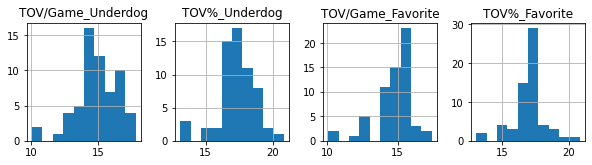

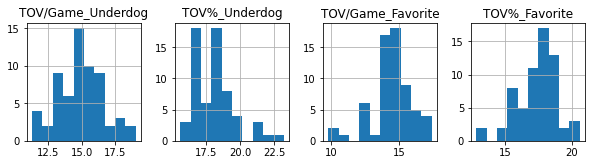

In [12]:
# View the distributions of the dataset's turnover features
tov_null_years = sorted(list(set(tov_nulls_rows['Year'])))

for year in tov_null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[tov_null_fills].hist(figsize=(10, 5), layout=(len(tov_null_years), len(tov_null_fills)))

array([[<AxesSubplot:title={'center':'PF/Game_Favorite'}>,
        <AxesSubplot:title={'center':'PF/Game_Underdog'}>]], dtype=object)

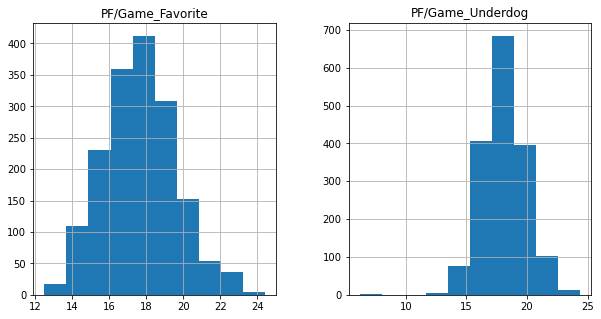

In [13]:
# View the distributions of the dataset's personal foul features
mm_matchups_df[pf_null_fills].hist(figsize=(10, 5), layout=(1, len(pf_null_fills)))

### Impute TOV Nulls by Season

In [14]:
# Retrieve TOV feature means by season; only include seasons that contain nulls
tov_col_means = mm_matchups_df[tov_nulls_rows.columns].groupby('Year').mean()
tov_col_means.loc[tov_null_years]

,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
Year,,,,
1993,14.909836,17.281967,14.787097,17.066129
2000,14.916129,18.106452,14.520635,17.384127


In [15]:
for year in tov_null_years:
    for col in tov_null_fills:
        # Get feature's rows with nulls for given year
        col_fill_rows = tov_nulls_rows[tov_nulls_rows['Year'] == year].index
        # Get feature's mean for given year
        col_year_mean = np.round(tov_col_means.loc[year, col], 1)
        # Impute nulls of interest
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)

# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[tov_nulls_rows.index, tov_null_fills]

,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
15,14.9,17.3,15.6,17.4
16,14.9,17.3,12.0,15.9
45,17.8,16.6,14.8,17.1
481,14.9,18.1,15.8,17.8


### Impute PF Nulls Using Entire Distribution

In [16]:
# Retrieve PF feature means; only found in one season
pf_col_means = mm_matchups_df[pf_null_fills].mean()
pf_col_means

PF/Game_Favorite    17.635175
PF/Game_Underdog    18.108200
dtype: float64

In [17]:
for col in pf_null_fills:
    # Get feature's mean
    col_mean = np.round(mm_matchups_df[col].mean(), 1)
    # Impute nulls of interest
    mm_matchups_df[col].fillna(col_mean, inplace=True)
    
# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[pf_nulls_rows.index, pf_null_fills]

,PF/Game_Favorite,PF/Game_Underdog
568,17.6,18.1
569,17.6,18.1
570,17.6,18.1
571,17.6,18.1
572,17.6,18.1
...,...,...
627,17.6,18.1
628,17.6,18.1
629,17.6,18.1
630,17.6,18.1


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA:
 - What is our bracket's accuracy if we guess the favorite always wins?
 - How often do upsets occur in a given year's March Madness?
 - What is the distribution of upsets across the tournament rounds?
 - Which seeding combinations are most likely to produce upsets?

## What is our Bracket's Accuracy if We Guess the Favorite Always Wins?

This is a strategy many of us have employed at least once while filling out a March Madness bracket, myself included. This is a classic EDA question which explores the idea of the base rate: historically, how often would we be right if we always assumed the favorite won the March Madness matchup? ~68.6% of our predictions would be correct according to our data, approximately 2 out of every 3 games. This means that for any model to be of value to us, it must demonstrate >68.6% of its predictions are correct.

In college basketball, the best (and thus most impactful) players typically leave the NCAA after no more than 2 years. Thus, a 2-year moving average was chosen to illustrate the base rate's trends as new impactful players participate in March Madness. Our base rate is maintained fairly consistently over time, with a few exceptions scattered across the dataset's time horizon.

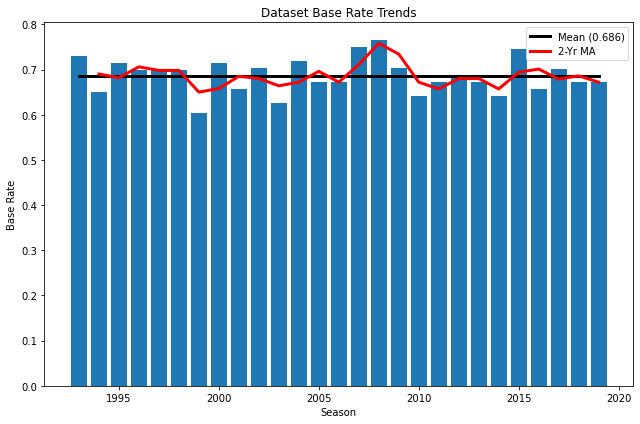

In [18]:
# Each season's base rate
yearly_base_rates = get_yearly_base_rates(mm_matchups_df)
# Dataset's mean base rate
mean_base_rate = np.round(yearly_base_rates.mean(), 3)
# Moving average
years_ma = 2
base_rate_ma = np.round(yearly_base_rates.rolling(years_ma).mean(), 3)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_base_rates.index, [mean_base_rate] * len(yearly_base_rates), color='k', linewidth=3, label=f'Mean ({mean_base_rate})')
plt.plot(yearly_base_rates.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rates.index, yearly_base_rates)

format_plot(title='Dataset Base Rate Trends', xlabel='Season', ylabel='Base Rate')

## How Often Do Upsets Occur in a Given Year's March Madness?

If favorites win March Madness matchups ~68.6% of the time, then we can conclude the underdogs are winning the other 31.4%; this translates to approximately 20 upsets per year. This knowledge gives us insight into how many upsets we should expect our model to predict (i.e. 25 is likely too high, 15 is likely too low).

A 2-year moving average has been employed once again to highlight the trends present across the dataset's time horizon. At first it may appear to be more volatile than the base rate trends, but this is simply due to the scale of the y-axis.

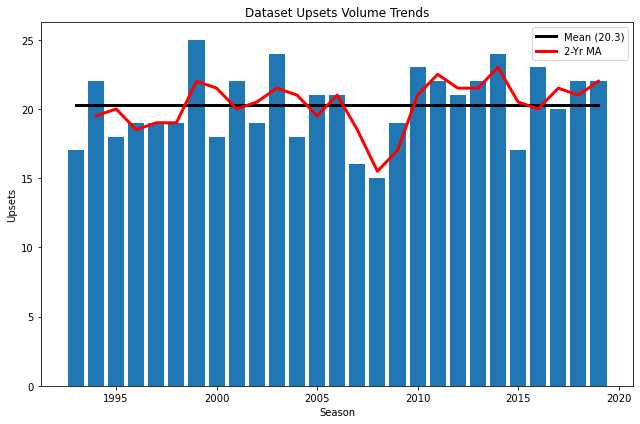

In [19]:
# Each season's upset count
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': 'sum'})
# Dataset's mean upset count
mean_upsets = np.round(yearly_upsets['Underdog_Upset'].mean(), 1)
# Moving average
upsets_ma = np.round(yearly_upsets.rolling(years_ma).mean(), 1)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_upsets.index, [mean_upsets] * len(yearly_upsets), color='k', linewidth=3, label=f'Mean ({mean_upsets})')
plt.plot(yearly_upsets.index, upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_upsets.index, yearly_upsets['Underdog_Upset'])

format_plot(title='Dataset Upsets Volume Trends', xlabel='Season', ylabel='Upsets')

## What is the Distribution of Upsets Across the Tournament Rounds?

Of the 20 upsets that we can expect in any given March Madness, the visualization below gives us an idea of how many upsets we can expect in each round. Nearly 70% of all upsets happen in the first 2 rounds, which is sensible given that 75% of all games are held in the first 2 rounds. Fewer upsets in each successive round is expected not only because of a diminished volume of games, but also a greater saturation of top-tier teams amongst the remaining teams in contention. We should expect our model to follow a similar pattern.

In [20]:
# Retrieve data about March Madness matchup seed pairings
seed_pairs = get_seed_pairs(mm_matchups_df)

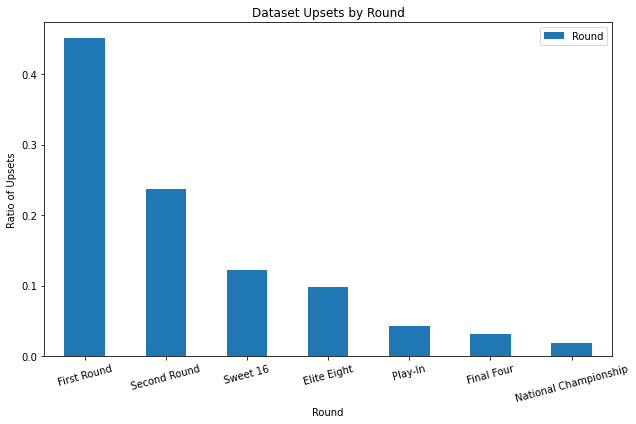

In [21]:
# Extract seed pairs that resulted in upsets
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]
# Group upset seed pairs by round and count them
upset_rounds_freq = upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Dataset Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

## Which Seeding Combinations are the Most Likely to Produce Upsets?

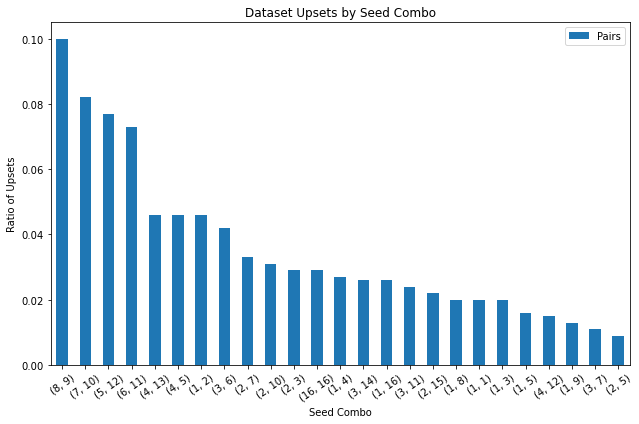

In [22]:
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)
upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Dataset Upsets by Seed Combo', xlabel='Seed Combo', ylabel='Ratio of Upsets')

# Feature Engineering & Analysis

In [23]:
mm_matchups_df.drop(['Year', 'Team_Favorite', 'Team_Underdog'], axis=1, inplace=True)
all_rounds = mm_matchups_df['Round']

X = mm_matchups_df.drop('Underdog_Upset', axis=1)
y = mm_matchups_df['Underdog_Upset']

display(X), display(y)

,Round,Seed_Favorite,Seed_Underdog,G_Favorite,W-L%_Favorite,SOS_Favorite,FG%_Favorite,3P%_Favorite,FT%_Favorite,FTr_Favorite,...,Opp./Game_Underdog,FG/Game_Underdog,3P/Game_Underdog,FT/Game_Underdog,TRB/Game_Underdog,AST/Game_Underdog,STL/Game_Underdog,BLK/Game_Underdog,TOV/Game_Underdog,PF/Game_Underdog
0,National Championship,1,1,38.0,0.895,11.25,0.506,0.372,0.706,0.392,...,71.8,31.4,4.2,14.9,41.5,16.3,6.8,5.4,15.6,18.6
1,Final Four,1,1,34.0,0.882,9.23,0.480,0.394,0.688,0.359,...,71.8,31.4,4.2,14.9,41.5,16.3,6.8,5.4,15.6,18.6
2,Final Four,1,2,38.0,0.895,11.25,0.506,0.372,0.706,0.392,...,69.7,30.8,6.0,16.8,36.1,19.1,9.1,2.9,14.5,17.6
3,Elite Eight,1,2,35.0,0.886,11.09,0.522,0.425,0.717,0.459,...,69.7,30.8,6.0,16.8,36.1,19.1,9.1,2.9,14.5,17.6
4,Elite Eight,1,2,38.0,0.895,11.25,0.506,0.372,0.706,0.392,...,58.5,28.1,5.0,13.2,36.0,16.0,10.0,2.6,14.1,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,First Round,7,10,35.0,0.857,0.80,0.490,0.414,0.704,0.271,...,71.9,26.1,7.1,14.5,35.7,13.5,6.9,3.9,12.4,18.8
1743,First Round,6,11,36.0,0.889,2.62,0.462,0.337,0.687,0.327,...,73.4,26.4,7.1,17.6,39.7,13.5,6.3,3.2,13.7,19.9
1744,Play-In,11,11,33.0,0.818,-2.60,0.498,0.372,0.737,0.286,...,71.5,26.5,7.5,14.3,34.4,14.4,8.6,2.2,11.2,17.6
1745,Play-In,16,16,35.0,0.543,-2.07,0.454,0.365,0.777,0.318,...,66.6,25.7,6.5,13.5,37.2,15.5,6.1,2.7,15.1,17.9


0       0
1       1
2       0
3       1
4       0
       ..
1742    0
1743    0
1744    0
1745    0
1746    0
Name: Underdog_Upset, Length: 1747, dtype: int64

(None, None)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.drop('Round', axis=1, inplace=True)
X_test.drop('Round', axis=1, inplace=True)

fit_df = X_train
prep_X_train = feature_pipeline(X_train, fit_df)
prep_X_test = feature_pipeline(X_test, fit_df)

prep_all_X = pd.concat([prep_X_train, prep_X_test])
prep_all_X

,Seed_Favorite,Seed_Underdog,Underdog_Rel_PF/Game,Underdog_Rel_AST%,Underdog_Rel_eFG%,Underdog_Rel_FG%,Underdog_Rel_S16,Underdog_Rel_W-L%,Underdog_Rel_3P/Game,Underdog_Rel_TOV/Game,...,Underdog_Rel_FT/FGA,Underdog_Rel_Champs,Underdog_Rel_STL/Game,Underdog_Rel_FT/Game,Underdog_Rel_FT%,Underdog_Rel_AST/Game,Underdog_Rel_FTr,Underdog_Rel_Top_25,Underdog_Rel_BLK%,Underdog_Rel_BLK/Game
806,-0.261437,1.020348,-1.094228,1.305060,1.630170,1.871235,-1.706116,0.147860,-0.489011,-1.317778,...,0.533246,-0.612783,-1.131292,-0.281582,-1.624924,0.686269,1.148293,-0.912227,-0.076950,-0.279008
591,1.103901,0.014579,0.025945,-0.742146,1.097903,1.026715,-1.185827,1.613595,0.607976,-2.255495,...,0.243955,0.352333,-0.576087,0.450162,1.794937,-0.005740,-0.472760,0.887747,-0.342643,-0.517804
1517,-0.602772,-1.745517,0.265983,1.465912,-0.582941,0.052268,-0.145249,0.432631,-1.421451,-0.824243,...,0.409264,0.352333,0.231483,0.565700,-0.916668,1.215453,0.802049,0.887747,-0.289504,-0.577503
1313,-0.944107,1.523233,0.065952,-0.186476,-1.731518,-1.636772,0.028181,-1.208993,-0.598710,-1.071011,...,-1.698426,0.352333,0.332429,-1.668044,-0.795253,-0.616337,-1.432800,-0.912227,1.384360,0.914971
440,0.421232,0.517464,0.466014,-0.873752,-0.470885,0.019787,-0.318679,0.306997,-0.763258,-0.478768,...,-1.512453,0.352333,0.231483,-0.782249,-0.329829,0.116379,-1.495754,-0.912227,0.188743,0.377680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,-0.944107,-1.494075,-0.974210,1.729124,0.173439,0.052268,-1.012398,-0.095034,0.169181,0.014767,...,0.202628,-0.612783,-0.777980,0.103546,1.693757,1.256159,-0.425544,0.887747,-1.086583,-0.875998
1453,0.079897,-1.242633,-0.334110,0.018245,-0.162730,-0.662326,-1.879546,1.211565,1.046771,-0.528122,...,0.512582,-1.577898,0.635268,0.758265,0.560549,-0.127860,0.314159,-0.912227,0.454435,0.616476
893,0.079897,-1.242633,-0.174086,0.880996,0.761734,0.701899,0.895329,0.910042,0.772524,0.113474,...,-1.305817,0.352333,2.553247,-0.859275,-1.705867,1.500398,-0.677358,0.887747,0.268450,0.258282
1004,0.079897,0.768906,0.706051,-0.054870,0.033368,-0.012695,-1.359257,-0.312800,-0.050216,0.458949,...,-2.277007,-1.577898,0.685741,-2.592353,-0.876197,-0.249979,-2.062335,-0.912227,-1.617968,-2.965461


## What are the Distributions of all our Features?

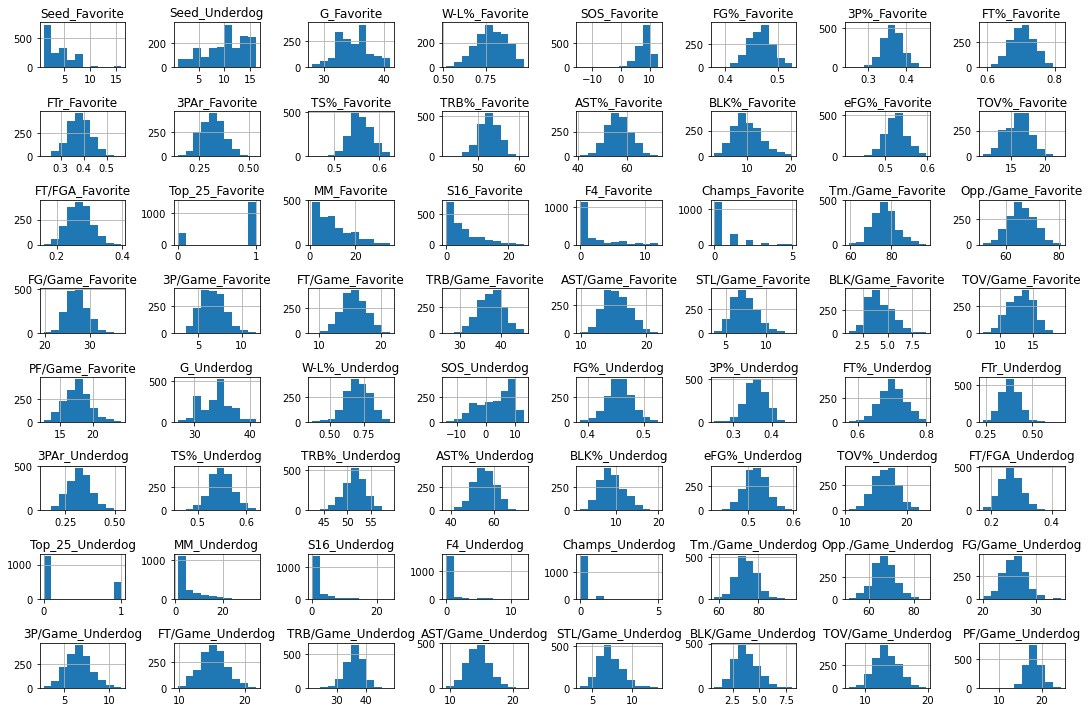

In [25]:
X.hist(figsize=(15, 10))
plt.tight_layout()

## What are the Correlations Between Features?

No handles with labels found to put in legend.


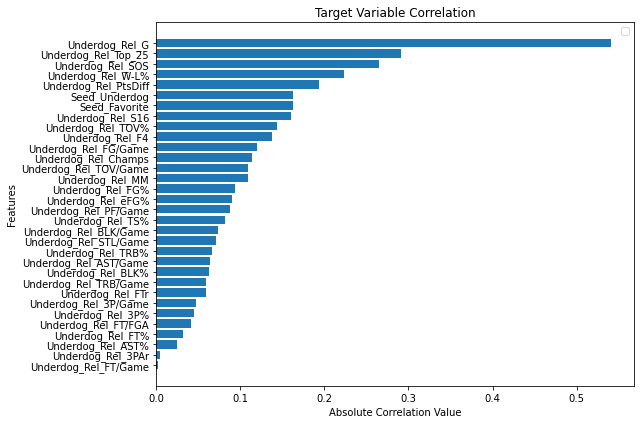

In [26]:
prep_X_y = prep_X_train.merge(y_train, left_index=True, right_index=True)
abs_desc_corr = np.abs(prep_X_y.corr().loc['Underdog_Upset']).sort_values()
abs_desc_corr.drop('Underdog_Upset', inplace=True)

plt.figure(figsize=(9, 6))
plt.barh(abs_desc_corr.index, abs_desc_corr.values)

format_plot(title='Target Variable Correlation', xlabel='Absolute Correlation Value', ylabel='Features')

## What Features have the Greatest Predictive Power?

No handles with labels found to put in legend.


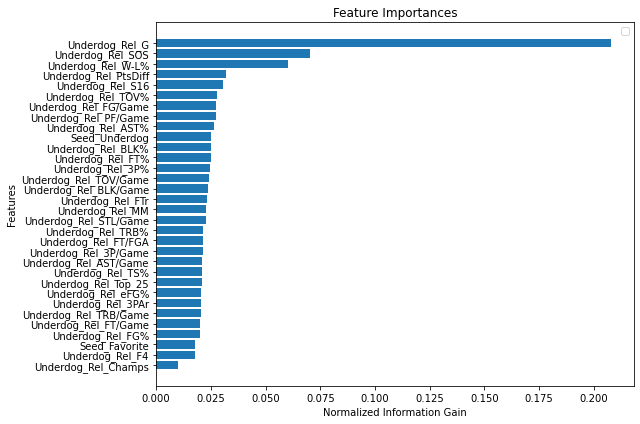

In [27]:
rf = RandomForestClassifier().fit(prep_X_train, y_train)

# Sort features & their corresponding values in by importance
importances = rf.feature_importances_
feat_importances = prep_all_X.columns[np.argsort(importances)]
feat_values = np.sort(importances)

# Plot feature importances calculated above
plt.figure(figsize=(9, 6))
plt.barh(feat_importances, feat_values)

format_plot(title='Feature Importances', xlabel='Normalized Information Gain', ylabel='Features')

# Model Selection

In [28]:
cv_models = get_cv_models(y)
model_performance = evaluate_cv_models(cv_models, prep_X_train, y_train)

model_performance

,Mean_Accuracy,Mean_Accuracy_Std,Mean_AUC,Mean_AUC_Std
KNN,0.735,0.007,0.781,0.014
Naive Bayes,0.742,0.016,0.795,0.018
LogReg,0.778,0.007,0.844,0.016
SVM,0.797,0.010,0.848,0.014
Random Forest,0.750,0.007,0.797,0.019


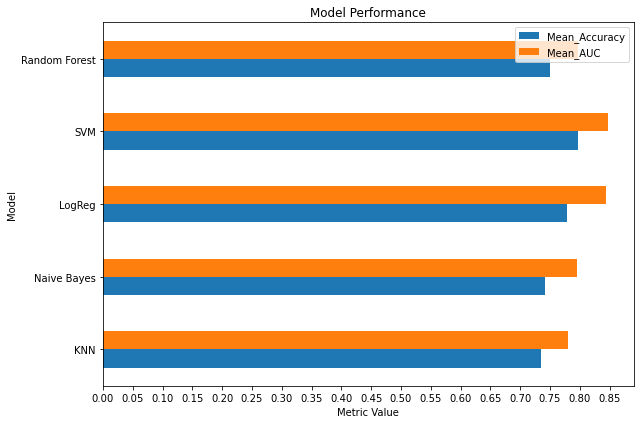

In [29]:
model_performance[['Mean_Accuracy', 'Mean_AUC']].plot(figsize=(9, 6), kind='barh', xticks=np.arange(0, 0.9, 0.05))

format_plot(title='Model Performance', xlabel='Metric Value', ylabel='Model')

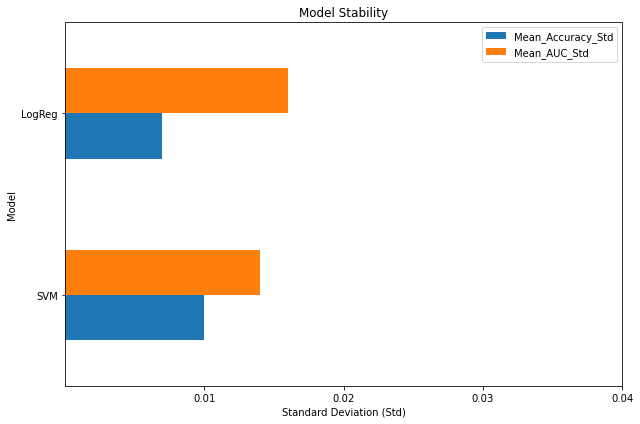

In [30]:
model_performance.loc[['SVM', 'LogReg'], ['Mean_Accuracy_Std', 'Mean_AUC_Std']].plot(
    figsize=(9, 6), kind='barh', xticks=np.arange(0.01, 0.05, 0.01)
)

format_plot(title='Model Stability', xlabel='Standard Deviation (Std)', ylabel='Model')

# Model Evaluation

In [31]:
best_model = cv_models['LogReg'][-1].best_estimator_
y_preds = best_model.predict(prep_X_test)

display(best_model)

LogisticRegression(C=0.1, random_state=42)

In [32]:
test_game_data = pd.concat([y_test, all_rounds, mm_matchups_df[['Seed_Favorite', 'Seed_Underdog']]], 
                           join='inner', axis=1).drop('Underdog_Upset', axis=1)
test_game_data['Underdog_Upset'] = y_preds

test_seed_pairs = get_seed_pairs(test_game_data)

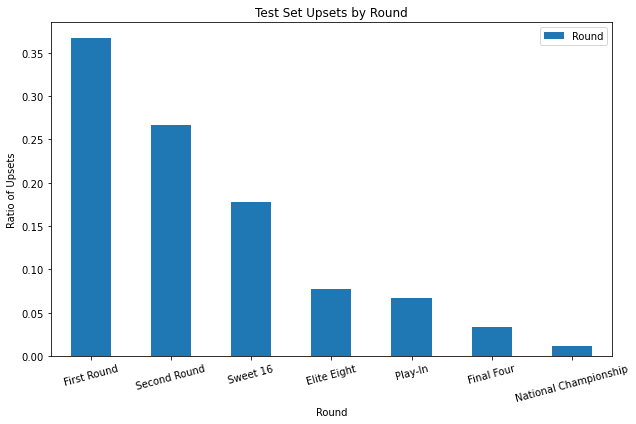

In [33]:
test_upset_pairs = test_seed_pairs[test_seed_pairs['Underdog_Upset'] == 1]
test_upset_rounds_freq = test_upset_pairs['Round'].value_counts(normalize=True)
test_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Test Set Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

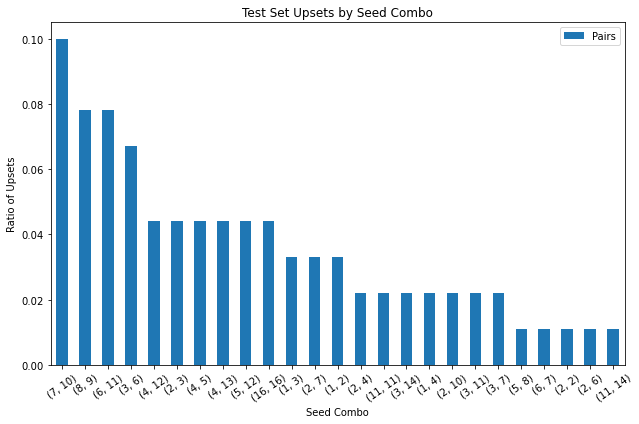

In [34]:
test_upset_pairs_freq = np.round(test_upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)
test_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Test Set Upsets by Seed Combo', xlabel='Seed Combo', ylabel='Ratio of Upsets')

In [35]:
report = get_classification_report(y_test, y_preds)
print("Test Set Metrics Report \n\n", report)

Test Set Metrics Report 

               precision    recall  f1-score   support

           0       0.84      0.91      0.88       240
           1       0.77      0.63      0.69       110

    accuracy                           0.82       350
   macro avg       0.80      0.77      0.78       350
weighted avg       0.82      0.82      0.82       350



# 2021 March Madness Predictions

## Data Pipeline

In [36]:
try:
    curr_bracket_df = pd.read_csv(f'{curr_year}_march_madness_curr_start_bracket.csv')
except FileNotFoundError:
    curr_bracket_df = fetch.get_current_bracket('http://www.espn.com/mens-college-basketball/tournament/bracket')
    curr_bracket_df.to_csv(f'{curr_year}_march_madness_curr_start_bracket.csv', index=False)
    
play_in = curr_bracket_df[:4]
play_in = play_in.reindex([0, 1, 3, 2])

first_round = curr_bracket_df[4:]
first_round.index = range(len(first_round))

display(play_in), display(first_round)

,Seed,Team,Seed.1,Team.1
0,16,Norfolk St,16,Appalachian State
1,11,Wichita State,11,Drake
3,16,Mount St. Mary's,16,Texas Southern
2,11,Michigan State,11,UCLA


,Seed,Team,Seed.1,Team.1
0,1,Gonzaga,16,NaN
1,8,Oklahoma,9,Missouri
2,5,Creighton,12,UC Santa Barbara
3,4,Virginia,13,Ohio
4,6,USC,11,NaN
5,3,Kansas,14,Eastern Washington
6,7,Oregon,10,VCU
7,2,Iowa,15,Grand Canyon
8,1,Michigan,16,NaN
9,8,LSU,9,St. Bonaventure


(None, None)

In [37]:
bracket_preds = bracket_pipeline(curr_year, play_in, first_round, best_model, fit_df, null_drops)
display(bracket_preds)

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,Norfolk St,16,Appalachian State,Play-In,1,Appalachian State
1,11,Drake,11,Wichita State,Play-In,0,Drake
2,16,Texas Southern,16,Mount St. Mary's,Play-In,0,Texas Southern
3,11,UCLA,11,Michigan State,Play-In,0,UCLA
4,1,Gonzaga,16,Appalachian State,First Round,0,Gonzaga
...,...,...,...,...,...,...,...
62,3,Arkansas,9,Wisconsin,Elite Eight,0,Arkansas
63,2,Houston,12,Oregon State,Elite Eight,1,Oregon State
64,2,Alabama,6,USC,Final Four,0,Alabama
65,3,Arkansas,12,Oregon State,Final Four,0,Arkansas


## Pre-Tournament Model Evaluation (3/17/21)

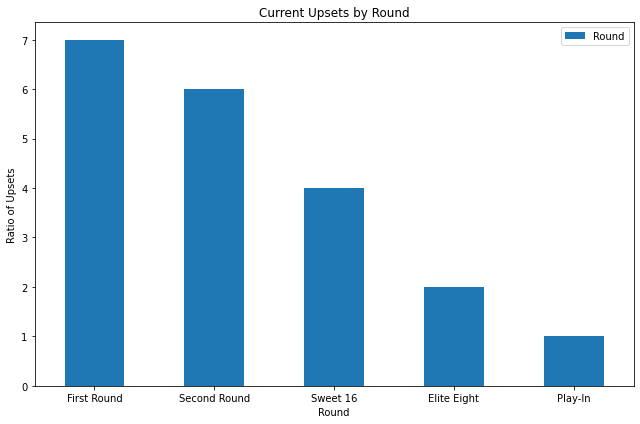

In [38]:
curr_seed_pairs = get_seed_pairs(bracket_preds)
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

curr_upset_rounds_freq = curr_upset_pairs['Round'].value_counts()
curr_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='Current Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

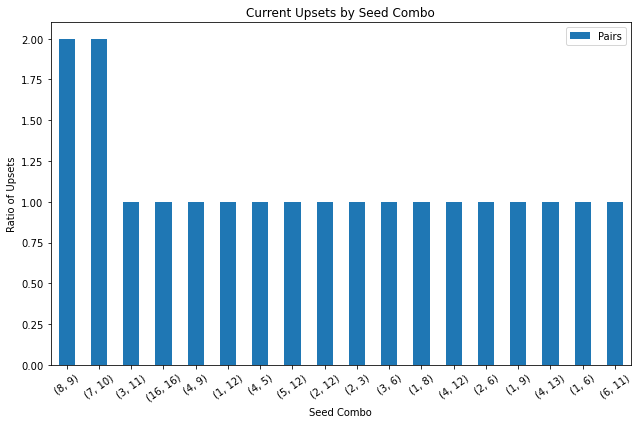

In [39]:
curr_seed_pairs = get_seed_pairs(bracket_preds)
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

curr_upset_pairs_freq = curr_upset_pairs['Pairs'].value_counts()
curr_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Current Upsets by Seed Combo', xlabel='Seed Combo', ylabel='Ratio of Upsets')

In [40]:
for _round in bracket_preds['Round'].unique():
    display(bracket_preds[bracket_preds['Round'] == _round])

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,Norfolk St,16,Appalachian State,Play-In,1,Appalachian State
1,11,Drake,11,Wichita State,Play-In,0,Drake
2,16,Texas Southern,16,Mount St. Mary's,Play-In,0,Texas Southern
3,11,UCLA,11,Michigan State,Play-In,0,UCLA


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
4,1,Gonzaga,16,Appalachian State,First Round,0,Gonzaga
5,8,Oklahoma,9,Missouri,First Round,1,Missouri
6,5,Creighton,12,UC Santa Barbara,First Round,0,Creighton
7,4,Virginia,13,Ohio,First Round,0,Virginia
8,6,USC,11,Drake,First Round,0,USC
9,3,Kansas,14,Eastern Washington,First Round,0,Kansas
10,7,Oregon,10,VCU,First Round,0,Oregon
11,2,Iowa,15,Grand Canyon,First Round,0,Iowa
12,1,Michigan,16,Texas Southern,First Round,0,Michigan
13,8,LSU,9,St. Bonaventure,First Round,0,LSU


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
36,1,Gonzaga,9,Missouri,Second Round,0,Gonzaga
37,4,Virginia,5,Creighton,Second Round,1,Creighton
38,3,Kansas,6,USC,Second Round,1,USC
39,2,Iowa,7,Oregon,Second Round,0,Iowa
40,1,Michigan,8,LSU,Second Round,1,LSU
41,5,Colorado,13,UNC Greensboro,Second Round,0,Colorado
42,3,Texas,11,UCLA,Second Round,1,UCLA
43,2,Alabama,10,Maryland,Second Round,0,Alabama
44,1,Baylor,9,Wisconsin,Second Round,1,Wisconsin
45,4,Purdue,5,Villanova,Second Round,0,Purdue


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
52,1,Gonzaga,5,Creighton,Sweet 16,0,Gonzaga
53,2,Iowa,6,USC,Sweet 16,1,USC
54,5,Colorado,8,LSU,Sweet 16,0,Colorado
55,2,Alabama,11,UCLA,Sweet 16,0,Alabama
56,4,Purdue,9,Wisconsin,Sweet 16,1,Wisconsin
57,2,Ohio State,3,Arkansas,Sweet 16,1,Arkansas
58,1,Illinois,12,Oregon State,Sweet 16,1,Oregon State
59,2,Houston,3,West Virginia,Sweet 16,0,Houston


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
60,1,Gonzaga,6,USC,Elite Eight,1,USC
61,2,Alabama,5,Colorado,Elite Eight,0,Alabama
62,3,Arkansas,9,Wisconsin,Elite Eight,0,Arkansas
63,2,Houston,12,Oregon State,Elite Eight,1,Oregon State


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
64,2,Alabama,6,USC,Final Four,0,Alabama
65,3,Arkansas,12,Oregon State,Final Four,0,Arkansas


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
66,2,Alabama,3,Arkansas,National Championship,0,Alabama


## Post-Tournament Model Evaluation